In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 线性回归的从零开始实现

## 生成数据集

In [4]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw + b +噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    '''
    normal(mean, std, *, generator=None, out=None) -> Tensor
    
    mean (float): the mean for all distributions
    std (float): the standard deviation for all distributions
    size (int...): a sequence of integers defining the shape of the output tensor.
    
    Returns a tensor of random numbers drawn from separate normal distributions
    whose mean and standard deviation are given.
    '''
    y = torch.matmul(X, w) + b
    '''
    matmul(input, other, *, out=None) -> Tensor
    Matrix product of two tensors
    '''
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0], '\nlabel:',labels[0])

features: tensor([ 0.2331, -0.4954]) 
label: tensor([6.3522])


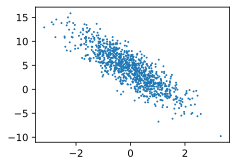

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
# torch.detach()返回一个新的tensor，从当前计算图中分离下来，但是仍指向原变量的存放位置，不同之处只是requires_grad为false，得到的这个
# tensor永远不需要计算其梯度，不具有gradient
# .numpy()是将tensor转化为array

In [25]:
features[:, (1)]

tensor([-4.9540e-01, -1.1098e+00,  5.7432e-01, -5.2599e-01, -9.1754e-01,
         1.1380e+00, -2.1831e-01, -6.7035e-02,  6.3886e-01,  3.3298e-01,
         9.2258e-01,  2.5066e-01,  4.7859e-01, -8.5992e-01,  5.6434e-01,
         1.9728e-01, -6.3160e-01,  4.6971e-01, -7.5834e-01, -4.5292e-02,
        -1.4915e+00,  1.4853e-01, -3.8146e-01,  5.0733e-02,  2.4268e-01,
        -1.4769e+00,  4.0988e-01,  1.3687e+00,  4.8802e-02,  4.2210e-01,
         1.1338e-01,  7.3530e-02,  1.7229e+00, -8.0216e-01,  1.5528e-01,
         5.5878e-01, -1.1396e+00,  1.3025e+00, -1.3895e+00, -1.5639e+00,
        -4.3720e-01,  1.1694e-01,  1.9868e-01, -5.6755e-01,  5.0244e-01,
         4.9127e-01,  5.9484e-01,  8.7649e-01,  4.5937e-01, -1.7231e-01,
         4.4627e-01, -4.7662e-01, -1.4246e+00, -7.7900e-02,  1.6487e+00,
        -2.0591e+00,  3.9138e-01, -2.2541e+00,  1.3261e+00, -1.5637e+00,
         1.4876e+00,  9.4479e-01,  2.4155e+00,  1.0410e+00,  1.4973e-01,
        -8.1138e-01,  1.5034e-01,  3.7954e-01, -3.2

In [26]:
features[:, (1)].detach().numpy()

array([-4.95398134e-01, -1.10983002e+00,  5.74323535e-01, -5.25987804e-01,
       -9.17535543e-01,  1.13802016e+00, -2.18309745e-01, -6.70345724e-02,
        6.38862669e-01,  3.32982033e-01,  9.22578454e-01,  2.50663161e-01,
        4.78593647e-01, -8.59919608e-01,  5.64340532e-01,  1.97278157e-01,
       -6.31600320e-01,  4.69714135e-01, -7.58342922e-01, -4.52920310e-02,
       -1.49153638e+00,  1.48534000e-01, -3.81459415e-01,  5.07327579e-02,
        2.42677569e-01, -1.47693300e+00,  4.09876019e-01,  1.36873460e+00,
        4.88021150e-02,  4.22104001e-01,  1.13375910e-01,  7.35298842e-02,
        1.72290540e+00, -8.02161753e-01,  1.55278280e-01,  5.58779836e-01,
       -1.13958740e+00,  1.30248356e+00, -1.38946319e+00, -1.56388974e+00,
       -4.37196553e-01,  1.16942696e-01,  1.98676020e-01, -5.67550778e-01,
        5.02444386e-01,  4.91270095e-01,  5.94837368e-01,  8.76494348e-01,
        4.59365189e-01, -1.72314808e-01,  4.46271420e-01, -4.76624370e-01,
       -1.42461514e+00, -

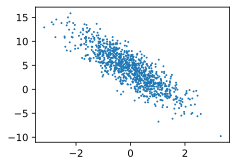

In [23]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)], labels, 1)

## 读取数据集

In [31]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
                        indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

关于yield
https://blog.csdn.net/mieleizhi0522/article/details/82142856

https://www.runoob.com/w3cnote/python-yield-used-analysis.html

### 关于yield
官方的相关文档：
https://docs.python.org/3/reference/expressions.html#yieldexpr
The yield expression is used when defining a generator function or an asynchronous generator function and thus can only be used in the body of a function definition. Using a yield expression in a function's body causes that function to be a generator function, and using it in an async def function's body causes that coroutine function to be an asynchronous generator function. 

Generator functions are described below:
WHen a generator function is called, it returns an iterator known as a generator. That generator then controls the execution of the generator function. THe execution starts when one of the generator's methods is called. At that time, the execution proceeds to the first yield expression, where it is suspended again, returning the value of expression_list to the generator's caller. By suspended, we mean that all local state is retained, including the current bindings of local variables, the instruction pointer, the internal evaluation stack, and the state of any exception handling. When the execution is resumed by called one of the generator's methods, the function can proceed exactly as if the yield expression were just another external call. The value of the yield expression after resuming depends on the method which resumed the execution. If **__next__()** is used (typically via either a **for** or the **next()** builtin) then the result is None. Otherwise, if **send()** is used, then the result will be the value passed in to that method. 

#### 关于yield的一些例子：

In [37]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
 
def fab(max): 
    n, a, b = 0, 0, 1 
    while n < max: 
        yield b      # 使用 yield
        # print b 
        a, b = b, a + b 
        n = n + 1
 
for n in fab(5): 
    print(n)

1
1
2
3
5


In [38]:
def foo():
    print("starting...")
    while True:
        res = yield 4
        print("res:", res)
g = foo()
print(next(g))
print("*"*20)
print(next(g))

starting...
4
********************
res: None
4


1.程序开始执行以后，因为foo函数中有yield关键字，所以foo函数并不会真的执行，而是先得到一个生成器g(相当于一个对象)

2.直到调用next方法，foo函数正式开始执行，先执行foo函数中的print方法，然后进入while循环

3.程序遇到yield关键字，然后把yield想想成return,return了一个4之后，程序停止，并没有执行赋值给res操作，此时next(g)语句执行完成，所以输出的前两行（第一个是while上面的print的结果,第二个是return出的结果）是执行print(next(g))的结果，

4.程序执行print("*"*20)，输出20个*

5.又开始执行下面的print(next(g)),这个时候和上面那个差不多，不过不同的是，这个时候是从刚才那个next程序停止的地方开始执行的，也就是要执行res的赋值操作，这时候要注意，这个时候赋值操作的右边是没有值的（因为刚才那个是return出去了，并没有给赋值操作的左边传参数），所以这个时候res赋值是None,所以接着下面的输出就是res:None,

6.程序会继续在while里执行，又一次碰到yield,这个时候同样return 出4，然后程序停止，print函数输出的4就是这次return出的4.
————————————————
版权声明：本文为CSDN博主「冯爽朗」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/mieleizhi0522/article/details/82142856

In [39]:
def foo():
    print("starting...")
    while True:
        res = yield 4
        print("res:", res)
g = foo()
print(next(g))
print("*"*20)
print(g.send(7))

starting...
4
********************
res: 7
4


关于next函数

官方文档：

next(iterator[, default])
Retrieve the next item from the iterator by calling its __next__() method. If default is given, it is returned if the iterator is exhausted, otherwise StopIteration is raised.

关于send函数

Description

Resumes the execution and “sends” a value into the generator function.

Syntax

**generator**.send(value)

**value**

Required. The value of the item to be sent.


In [40]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
 
# 首先获得Iterator对象:
it = iter([1, 2, 3, 4, 5])
# 循环:
while True:
    try:
        # 获得下一个值:
        x = next(it)
        print(x)
    except StopIteration:
        # 遇到StopIteration就退出循环
        break

1
2
3
4
5


### 测试数据

In [32]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.4952, -0.4068],
        [ 2.2147,  0.5948],
        [ 0.4247, -1.4869],
        [-0.1435,  1.2894],
        [-0.5034, -1.2130],
        [ 0.0949,  0.5116],
        [ 0.2738,  1.4671],
        [-0.0755,  0.2427],
        [-0.2920,  0.0059],
        [ 1.4959,  0.3317]]) 
 tensor([[ 2.6132],
        [ 6.6022],
        [10.1147],
        [-0.4640],
        [ 7.3121],
        [ 2.6351],
        [-0.2499],
        [ 3.2163],
        [ 3.5859],
        [ 6.0453]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

In [33]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [34]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [35]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

In [41]:
def sgd(params, lr, batch_size):  #@save
    # lr 学习速率
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

关于with关键字
Python 中的 with 语句用于异常处理，封装了 try…except…finally 编码范式，提高了易用性。

In [ ]:
file = open('./test_runoob.txt', 'w')
file.write('hello world !')
file.close()

In [ ]:
file = open('./test_runoob.txt', 'w')
try:
    file.write('hello world')
finally:
    file.close()

In [ ]:
with open('./test_runoob.txt', 'w') as file:
    file.write('hello world !')

关于torch.no_grad()
https://blog.csdn.net/weixin_46559271/article/details/105658654

## 训练

In [42]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040292
epoch 2, loss 0.000162
epoch 3, loss 0.000051


关于backward()
https://zhuanlan.zhihu.com/p/83172023

In [44]:
? torch.autograd.backward

In [6]:
X = torch.arange(12, dtype=torch.float32).reshape((3,4))
Y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

In [7]:
Z = torch.zeros_like(Y)
print('id(Z):', id(Z))
Z[:] = X + Y
print('id(Z):', id(Z))

id(Z): 2666865449936
id(Z): 2666865449936


# 线性回归的简洁实现

In [8]:
?torch.optim.SGD.step

## 生成数据集

In [9]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [10]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## 读取数据集

In [11]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

In [12]:
?data.TensorDataset

In [13]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [14]:
?iter

In [15]:
next(iter(data_iter))

[tensor([[-1.6240,  1.9367],
         [ 1.8325, -0.0672],
         [-0.8952,  0.0490],
         [-1.5298,  0.3997],
         [-0.6444, -0.9821],
         [-1.6968,  1.7394],
         [-0.0621, -0.3289],
         [ 0.5659, -0.8776],
         [-1.2169,  1.9199],
         [ 0.4393,  0.9344]]),
 tensor([[-5.6245],
         [ 8.0823],
         [ 2.2321],
         [-0.2217],
         [ 6.2433],
         [-5.1025],
         [ 5.1967],
         [ 8.3172],
         [-4.7676],
         [ 1.9175]])]

In [16]:
next(iter(data_iter))

[tensor([[ 0.1315,  3.1743],
         [-1.3147, -0.3650],
         [ 1.5230,  0.5118],
         [-1.4415,  1.6073],
         [-0.4438, -0.7191],
         [-0.7797, -0.6716],
         [-0.9817, -0.4945],
         [ 0.0431, -3.2945],
         [-1.1560,  0.6927],
         [-0.0112, -0.6805]]),
 tensor([[-6.3452],
         [ 2.8241],
         [ 5.5016],
         [-4.1540],
         [ 5.7444],
         [ 4.9084],
         [ 3.9141],
         [15.4904],
         [-0.4609],
         [ 6.4807]])]

## 定义模型

In [17]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## 初始化模型

In [23]:
net[0].weight.data.normal_(0, 0.01)

tensor([[-0.0181,  0.0195]])

In [24]:
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数

In [25]:
loss = nn.MSELoss()

## 定义优化算法

In [26]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

## 训练

In [27]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l : f}')

epoch 1, loss  0.000285
epoch 2, loss  0.000099
epoch 3, loss  0.000099


In [29]:
?trainer.zero_grad

**简洁实现的内核是线性回归的从零开始实现，其理解需要基于从零开始实现里面各细节的实现算法。**

# softmax回归

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [3]:
# 读取数据集
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train = True, transform = trans, download = True)
mnist_test = torchvision.datasets.FashionMNIST(
    root = "../data", train = False, transform=trans, download=True)

In [13]:
?transforms.ToTensor

In [5]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [6]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [7]:
# 对于数据集中包含的10个类别，在数字标签索引和其文本名称之间进行转换。
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-Mnist数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
                  'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [8]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5): #@save
    '''绘制图像列表'''
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            #图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [12]:
?enumerate

In [13]:
?zip

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

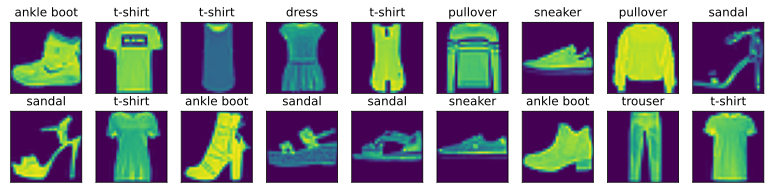

In [9]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size = 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [11]:
# 读取小批量
batch_size = 256

def get_dataloader_workers():   #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, 
                            num_workers = get_dataloader_workers())

In [12]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.12 sec'

In [20]:
# 整合所有组件
def load_data_fashion_mnist(batch_size, resize = None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train = True, transform = trans, download = True)
    mnist_test = torchvision.datasets.FashionMNIST(
    root = "../data", train = False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle = True, 
                            num_workers = get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle = True, 
                            num_workers = get_dataloader_workers()))

In [14]:
?transforms.Resize

In [21]:
?transforms.ToTensor

In [22]:
?transforms.Compose

**compose方法是将多种变换组合在一起。ToTesor将PILImage转化为torch.FloatTensor的数据形式。
list.insert(index, obj)用于将指定对象插入列表的指定位置。**

In [23]:
# 测试
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# softmax回归的从零开始实现

In [24]:
import torch
from IPython import display
from d2l import torch as d2l

In [25]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [26]:
# 初始化模型参数
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

In [27]:
# 定义softmax操作
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim = True)
    return X_exp / partition #这里应用了广播机制

In [30]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[ 0.5565,  1.4967,  0.9135,  0.9442,  0.0038],
         [-0.3566,  1.1915, -0.8670,  1.3610,  0.6820]]),
 tensor([[0.1421, 0.3638, 0.2030, 0.2094, 0.0818],
         [0.0680, 0.3199, 0.0408, 0.3790, 0.1922]]),
 tensor([1.0000, 1.0000]))

In [31]:
# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [32]:
# 定义损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [33]:
# 分类精度
# y_hat 是预测的概率分布，y是标签
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [65]:
# 评估任意模型net的精度
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()   #将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [66]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
[0.0] * 2

[0.0, 0.0]

In [43]:
?torch.numel

model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

More details: It sets the mode to train (see source code). You can call either model.eval() or model.train(mode=False) to tell that you are testing. It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode.

In [57]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumelator(3)
    for X, y in train_iter:
        #计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            #使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    #返回训练损失和训练精度
    return metric[0]/metric[2], metric[1]/metric[2]

In [68]:
# 定义一个在动画中绘制数据的实用程序类
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel = None, ylabel = None, legend = None, xlim = None, 
                ylim = None, xscale = 'linear', yscale = 'linear', 
                fmts = ('-', 'm--', 'g-.', 'r:'), nrows = 1, ncols = 1, 
                figsize = (3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [69]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim = [0.3, 0.9], 
                       legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
def sgd(params, lr, batch_size):  #@save
    # lr 学习速率
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [70]:
lr = 0.1
# 在这里参数得到更新
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

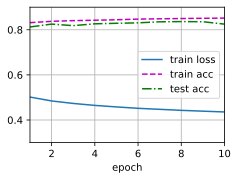

In [71]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

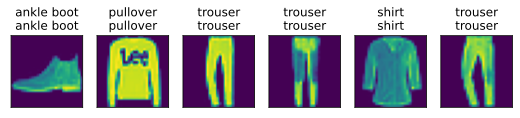

In [76]:
# 预测
def predict_ch3(net, test_iter, n = 6): #@save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles = titles[0:n])
    
predict_ch3(net, test_iter)

# softmax回归的简洁实现